In [9]:
#### DreamData.io 

"""Challenge: The task of this code challenge is to predict if a conversion (e.g. form
submission) would happen in or right after each session in the whole customer
journey. A conversion in this context means a user signs up so that the company
gets his contact information. A whole customer journey might contain one or
multiple sessions."""

""" Procedure:
1. load and explore data
2. how to define and unite the journey for one costumer?
3. clean data: drop sessions after user has converted?
4. work with a fraction of the dataset
5. build dependent variable
6. build dummy variables for categorical data
7. compare different techniques and sampeling methods
8. build final cross validated predictive model

class imbalance is too big for sampling:
next steps would be to clean the dataset further, to build journeys for each costumer
and to discuss which other problems may exist inherent to the type of data and how these can be adressed

After that, it would be interesting to look at other techniques, more specific to this kind of problem: maybe markov-chain models etc.

"""




' Procedure:\n1. load and explore data\n2. how to define and unite the journey for one costumer\n3. clean data: drop sessions after user has converted?\n4. work with a fraction of the dataset\n5. build dependent variable\n6. build dummy variables for categorical data\n7. compare different techniques and sampeling methods\n8. build final cross validated predictive model\n'

In [36]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [11]:
### Setup

# load data into pd
df_original = pd.read_csv("training_data.csv") 

df_original.shape

#df_original.isna().sum()


# preview the first 5 lines of data 
#df.head()

#Column types
#df_original.dtypes

#changing data types takes to long, because the dataset is big. Therefore we will work with a sample first
#pd.to_datetime(df_original.conversion_time)
#pd.to_datetime(df_original.session_end_time)
#pd.to_datetime(df_original.session_start_time)
#pd.to_datetime(df_original.later_session_start_time)

# Conversion counts
df_original['conversion'].value_counts()

#check that there is only true or false in the conversion counts
#df.conversion.unique()

False    2366475
True       39679
Name: conversion, dtype: int64

In [12]:
#extract a random sample to work with 25% of the data only - otherwise the processes take too long
df=df_original.sample(frac=0.25, random_state=1)
# Conversion counts
df['conversion'].value_counts()


False    591785
True       9753
Name: conversion, dtype: int64

In [13]:
# take each user with conversion=true and drop all the sessions after the conversion, as they are not relevant instances for solving the prediction problem
# takes way to long if it is done beofer sampling.....
user_ids_conv=df['user_id']
df_conv=df[df['conversion']==True]
user_ids_conv=df_conv['user_id']


for user in user_ids_conv:
    df.drop(df[(df['user_id']== user) & (df['conversion_time'] < df['session_start_time'])].index, inplace = True)
df.shape

(597784, 19)

In [15]:
#save the data into csv, to be loaded directly
#df.to_csv(r'training_data_sampled_journey.csv', index = False)
df_original = pd.read_csv("training_data_sampled_journey.csv") 
df_original.shape

(597784, 19)

In [16]:
#look at duplicate user_id s
#dupl_user = df.pivot_table(index=['user_id'], aggfunc='size')
#print (dupl_user)

#********************* look into how to compose one journey which may contain multiple sessions************************

In [17]:
#tpes of columns
df.dtypes

conversion                      bool
conversion_time               object
user_id                        int64
sessionId                      int64
minutes_since_last_session     int64
event                         object
browser                       object
os                            object
device                        object
channel                       object
session_end_time              object
session_start_time            object
event_count                    int64
country                       object
session_duration_seconds       int64
later_session_start_time      object
region                        object
sub_region                    object
source                        object
dtype: object

In [18]:
#create a new column with the dependent variable
df['dependent_variable'] = 0

count    597784.000000
mean       3507.106256
std       16735.994541
min           0.000000
25%           0.000000
50%           0.000000
75%          56.000000
max      369575.000000
Name: minutes_since_last_session, dtype: float64


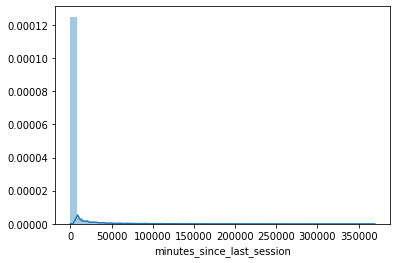

In [19]:
"""#look if conversion_time is after end of session
#create a new column for conversion after session with time delta
df['conversion_after_end'] = pd.to_datetime(df['conversion_time']) - pd.to_datetime(df['session_end_time'])
#df['conversion_after_end'].value_counts()
df.head(100)

--> can use minutes_since_last_session!!!"""
print(df['minutes_since_last_session'].describe())
sns.distplot(df['minutes_since_last_session'])


In [20]:
#insert dependent_variable value 1 if the conversion occcurred within the session
df.loc[(df['conversion_time'] < (df['session_end_time'])) & (df['conversion_time'] > df['session_start_time']), 'dependent_variable'] = 1
df['dependent_variable'].value_counts()

0    591785
1      5999
Name: dependent_variable, dtype: int64

In [21]:
#insert dependent_variable value 1 if the conversion occcurred right after the end of the session (max. 30 minutes)
df.loc[(df['minutes_since_last_session'] < 59) & (df['conversion'] == True), 'dependent_variable'] = 1
df['dependent_variable'].value_counts()
# positive exaples ~1.5%

#### THE DATASET IS HIGHLY UNBALANCED 

0    591785
1      5999
Name: dependent_variable, dtype: int64

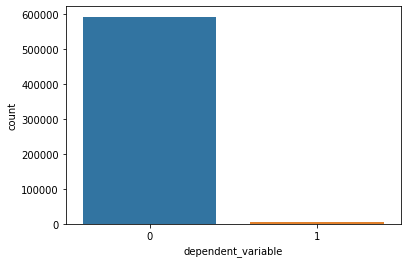

In [43]:
#visualize class distribution of dependent variable --> highly imbalanced data
sns.countplot(df['dependent_variable'])

In [23]:
print(df.columns.values)

['conversion' 'conversion_time' 'user_id' 'sessionId'
 'minutes_since_last_session' 'event' 'browser' 'os' 'device' 'channel'
 'session_end_time' 'session_start_time' 'event_count' 'country'
 'session_duration_seconds' 'later_session_start_time' 'region'
 'sub_region' 'source' 'dependent_variable']


In [24]:
# create dataset for prediction

df_data = df[['dependent_variable', 'event', 'browser', 'os', 'device', 
              'channel', 'minutes_since_last_session', 'event_count', 'session_duration_seconds', 'source']]
df_data.head()


,dependent_variable,event,browser,os,device,channel,minutes_since_last_session,event_count,session_duration_seconds,source
416985,0,page_view,Chrome,Windows,DESKTOP,direct,4,20,541,direct
172060,0,page_view,Chrome,Android,TABLET,Paid,20160,1,0,Google
2309822,0,page_view,Chrome,Windows,DESKTOP,referrer,121,3,12,referrer
788632,0,page_view,Safari,iOS,TABLET,Paid,101,1,0,Google
835362,0,page_view,Webkit based browser,iOS,MOBILE,Social,112900,1,0,LinkedIn


In [25]:
#look into categorical data to create dummy variables
"""for l in ['event', 'browser', 'os', 'device', 
              'channel','source']:
    print(l)
    print(df_data[l].value_counts())"""

"for l in ['event', 'browser', 'os', 'device', \n              'channel','source']:\n    print(l)\n    print(df_data[l].value_counts())"

In [26]:
#create dummy values for categorical variables
#should look into this more carefully and create a variable for 'others' when the value counts for a category is low
categorical_variables=['event', 'browser', 'os', 'device', 
              'channel','source']
for item in categorical_variables:
    dummies = pd.get_dummies(df_data[item]).rename(columns=lambda x: item+ '_' + str(x))
    df_data_new = pd.concat([df_data, dummies], axis=1)
    #df_data_new = df_data_new.drop(item) --why does that not work?
print(df_data_new.columns.values)

['dependent_variable' 'event' 'browser' 'os' 'device' 'channel'
 'minutes_since_last_session' 'event_count' 'session_duration_seconds'
 'source' 'source_Ask.com' 'source_Baidu' 'source_Banners' 'source_Bing'
 'source_Caspari' 'source_DIS' 'source_DMP' 'source_Display'
 'source_DuckDuckGo' 'source_Ecosia' 'source_Email' 'source_Facebook'
 'source_Google' 'source_Instagram' 'source_Kragen' 'source_LinkedIn'
 'source_MGWW' 'source_Marketing Vendor' 'source_Must See Promo'
 'source_MyWay' 'source_Naver' 'source_Newsletter Ad' 'source_Others'
 'source_Outlook' 'source_Paid Media' 'source_Pinterest'
 'source_Programmatic' 'source_RTB' 'source_Reddit' 'source_Slack'
 'source_SoMe' 'source_Twitter' 'source_Xing' 'source_YJP' 'source_Yahoo'
 'source_Yandex' 'source_Youtube' 'source_blog' 'source_direct'
 'source_eblast' 'source_ebooks' 'source_hs_automation'
 'source_organic_social_media' 'source_outbound' 'source_referrer'
 'source_sendinblue' 'source_sniply' 'source_vkontakte' 'source_wechat'

In [27]:
#drop the original categorical variables and show new data frame
for var in categorical_variables:
    df_data_new= df_data_new.drop(var, axis=1)
df_data_new.head()

,dependent_variable,minutes_since_last_session,event_count,session_duration_seconds,source_Ask.com,source_Baidu,source_Banners,source_Bing,source_Caspari,source_DIS,...,source_ebooks,source_hs_automation,source_organic_social_media,source_outbound,source_referrer,source_sendinblue,source_sniply,source_vkontakte,source_wechat,source_whippany
416985,0,4,20,541,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172060,0,20160,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2309822,0,121,3,12,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
788632,0,101,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835362,0,112900,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# split the dataset into train and test
X = df_data_new.drop('dependent_variable', axis = 1) 
y = df_data_new['dependent_variable']

#print(X)
#print(y)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the data - does not seem necessary
#from sklearn.preprocessing import StandardScaler
#feature_scaler = StandardScaler()
#X_train = feature_scaler.fit_transform(X_train)
#X_test = feature_scaler.transform(X_test)

#Do not perform feature selections as the number of features is low and they all seem relevant

In [29]:
X.shape

(597784, 53)

In [30]:
def classify(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Training set score: ", model.score(X_train, y_train))
    print("Test set score: ", model.score(X_test, y_test))
    #print the predictions
    #print(predictions)
    #Check precision, recall, f1-score
    print( classification_report(y_test, predictions))
    return (predictions, model)

In [31]:
#try different ML models
def buildmodels():

    #logistic regression
    print("Logistic Regression")
    logreg = LogisticRegression()
    logreg_pred, logreg=classify(logreg)

    #LinearSVC
    print("LinearSCV")
    lsvc = LinearSVC()
    lsv_pred, lsvc=classify(lsvc)

    #decision tree
    print("Decision Tree Cl")
    tree=DecisionTreeClassifier()
    tree_pred, tree=classify(tree)
    #print("feature imporatnces", tree.feature_importances_)

    #random forest
    print("Radnom Forest Cl")
    forest=RandomForestClassifier()
    forest_pred, forest=classify(forest)
    #print("feature imporatnces", forest.feature_importances_)

    #gradient boosting
    print("Gradient Boosting Cl")
    gbrt=GradientBoostingClassifier()
    gbrt_pred, gbrt=classify(gbrt)

    #MNeural Networks: MLPs
    print("MLP")
    mlp=MLPClassifier()
    mlp_pred, mlp=classify(mlp)

In [32]:
buildmodels()

Logistic Regression
Training set score:  0.9896283564081493
Test set score:  0.98953637177246
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    118344
           1       0.15      0.01      0.01      1213

    accuracy                           0.99    119557
   macro avg       0.57      0.50      0.50    119557
weighted avg       0.98      0.99      0.98    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9862722096410282
Test set score:  0.9861739588648093
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    118344
           1       0.05      0.02      0.03      1213

    accuracy                           0.99    119557
   macro avg       0.52      0.51      0.51    119557
weighted avg       0.98      0.99      0.98    119557

Decision Tree Cl
Training set score:  0.9977500224788647
Test set score:  0.982343150129227
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    118344
           1       0.09      0.08      0.08      1213

    accuracy                           0.98    119557
   macro avg       0.54      0.53      0.54    119557
weighted avg       0.98      0.98      0.98    119557

Radnom Forest Cl
Training set score:  0.9977291119071069
Test set score:  0.987629331615882
              precision    recall  f1-score   support

           0       0.99      1.

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    118344
           1       0.00      0.00      0.00      1213

    accuracy                           0.99    119557
   macro avg       0.49      0.50      0.50    119557
weighted avg       0.98      0.99      0.98    119557

MLP
Training set score:  0.9899922003567344
Test set score:  0.9898542117985564


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    118344
           1       0.00      0.00      0.00      1213

    accuracy                           0.99    119557
   macro avg       0.49      0.50      0.50    119557
weighted avg       0.98      0.99      0.98    119557



In [33]:
### WEIGHT CLASSES TO CHECK IF THE PERFORMANCE CAN BE IMPORVED
#try different sampling methods
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE

for method in [NearMiss(version=1), RandomUnderSampler(), AllKNN(), RandomOverSampler(), SMOTE(), KMeansSMOTE()]:
    X_res, y_res = method.fit_resample(X_train, y_train)
    X_train, y_train=X_res, y_res
    print(method)
    buildmodels()


NearMiss(n_jobs=None, n_neighbors=3, n_neighbors_ver3=3,
         sampling_strategy='auto', version=1)
Logistic Regression


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9419139155871291
Test set score:  0.6165929222044715
              precision    recall  f1-score   support

           0       1.00      0.61      0.76    118344
           1       0.02      0.91      0.05      1213

    accuracy                           0.62    119557
   macro avg       0.51      0.76      0.40    119557
weighted avg       0.99      0.62      0.75    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9184078562473882
Test set score:  0.5354182523817091
              precision    recall  f1-score   support

           0       1.00      0.53      0.69    118344
           1       0.02      0.87      0.04      1213

    accuracy                           0.54    119557
   macro avg       0.51      0.70      0.37    119557
weighted avg       0.99      0.54      0.69    119557

Decision Tree Cl
Training set score:  0.9692854157960719
Test set score:  0.44124559833384913
              precision    recall  f1-score   support

           0       1.00      0.44      0.61    118344
           1       0.02      0.95      0.03      1213

    accuracy                           0.44    119557
   macro avg       0.51      0.69      0.32    119557
weighted avg       0.99      0.44      0.60    119557

Radnom Forest Cl
Training set score:  0.9692854157960719
Test set score:  0.06087472920866198
              precision    recall  f1-score   support

           0       0.99    

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9419139155871291
Test set score:  0.6165678295708323
              precision    recall  f1-score   support

           0       1.00      0.61      0.76    118344
           1       0.02      0.92      0.05      1213

    accuracy                           0.62    119557
   macro avg       0.51      0.76      0.40    119557
weighted avg       0.99      0.62      0.75    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.916213957375679
Test set score:  0.5458484237643969
              precision    recall  f1-score   support

           0       1.00      0.54      0.70    118344
           1       0.02      0.85      0.04      1213

    accuracy                           0.55    119557
   macro avg       0.51      0.70      0.37    119557
weighted avg       0.99      0.55      0.70    119557

Decision Tree Cl
Training set score:  0.9692854157960719
Test set score:  0.4408022951395569
              precision    recall  f1-score   support

           0       1.00      0.44      0.61    118344
           1       0.02      0.95      0.03      1213

    accuracy                           0.44    119557
   macro avg       0.51      0.69      0.32    119557
weighted avg       0.99      0.44      0.60    119557

Radnom Forest Cl
Training set score:  0.9692854157960719
Test set score:  0.06671294863537894
              precision    recall  f1-score   support

           0       0.99      

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9697101765090433
Test set score:  0.6258939250733959
              precision    recall  f1-score   support

           0       1.00      0.62      0.77    118344
           1       0.02      0.90      0.05      1213

    accuracy                           0.63    119557
   macro avg       0.51      0.76      0.41    119557
weighted avg       0.99      0.63      0.76    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9588145565482676
Test set score:  0.603753857992422
              precision    recall  f1-score   support

           0       1.00      0.60      0.75    118344
           1       0.02      0.87      0.04      1213

    accuracy                           0.60    119557
   macro avg       0.51      0.73      0.40    119557
weighted avg       0.99      0.60      0.74    119557

Decision Tree Cl
Training set score:  0.9955327958160819
Test set score:  0.581597062489022
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    118344
           1       0.02      0.93      0.04      1213

    accuracy                           0.58    119557
   macro avg       0.51      0.76      0.39    119557
weighted avg       0.99      0.58      0.73    119557

Radnom Forest Cl
Training set score:  0.9955327958160819
Test set score:  0.21092867837098622
              precision    recall  f1-score   support

           0       1.00      0

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9683451734224823
Test set score:  0.6261615798322139
              precision    recall  f1-score   support

           0       1.00      0.62      0.77    118344
           1       0.02      0.90      0.05      1213

    accuracy                           0.63    119557
   macro avg       0.51      0.76      0.41    119557
weighted avg       0.99      0.63      0.76    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9657333890513999
Test set score:  0.5950132572747727
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    118344
           1       0.02      0.90      0.04      1213

    accuracy                           0.60    119557
   macro avg       0.51      0.75      0.39    119557
weighted avg       0.99      0.60      0.74    119557

Decision Tree Cl
Training set score:  0.9950898453823652
Test set score:  0.5815134203768914
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    118344
           1       0.02      0.93      0.04      1213

    accuracy                           0.58    119557
   macro avg       0.51      0.76      0.39    119557
weighted avg       0.99      0.58      0.73    119557

Radnom Forest Cl
Training set score:  0.994985374007522
Test set score:  0.21786260946661426
              precision    recall  f1-score   support

           0       1.00      

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9683451734224823
Test set score:  0.6261615798322139
              precision    recall  f1-score   support

           0       1.00      0.62      0.77    118344
           1       0.02      0.90      0.05      1213

    accuracy                           0.63    119557
   macro avg       0.51      0.76      0.41    119557
weighted avg       0.99      0.63      0.76    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9642707898035938
Test set score:  0.5849511111854596
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    118344
           1       0.02      0.93      0.04      1213

    accuracy                           0.58    119557
   macro avg       0.51      0.75      0.39    119557
weighted avg       0.99      0.58      0.73    119557

Decision Tree Cl
Training set score:  0.9950898453823652
Test set score:  0.5815803340665958
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    118344
           1       0.02      0.93      0.04      1213

    accuracy                           0.58    119557
   macro avg       0.51      0.76      0.39    119557
weighted avg       0.99      0.58      0.73    119557

Radnom Forest Cl
Training set score:  0.9950898453823652
Test set score:  0.22291459303930342
              precision    recall  f1-score   support

           0       1.00     

C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training set score:  0.9683451734224823
Test set score:  0.6261615798322139
              precision    recall  f1-score   support

           0       1.00      0.62      0.77    118344
           1       0.02      0.90      0.05      1213

    accuracy                           0.63    119557
   macro avg       0.51      0.76      0.41    119557
weighted avg       0.99      0.63      0.76    119557

LinearSCV


C:\Users\rraquel\.conda\envs\amb_env\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training set score:  0.9619724195570414
Test set score:  0.601436971486404
              precision    recall  f1-score   support

           0       1.00      0.60      0.75    118344
           1       0.02      0.88      0.04      1213

    accuracy                           0.60    119557
   macro avg       0.51      0.74      0.40    119557
weighted avg       0.99      0.60      0.74    119557

Decision Tree Cl
Training set score:  0.9950898453823652
Test set score:  0.5815301487993175
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    118344
           1       0.02      0.93      0.04      1213

    accuracy                           0.58    119557
   macro avg       0.51      0.76      0.39    119557
weighted avg       0.99      0.58      0.73    119557

Radnom Forest Cl
Training set score:  0.9950898453823652
Test set score:  0.22800003345684486
              precision    recall  f1-score   support

           0       1.00      

In [ ]:
#Class imbalance seems still to high, even after sampling.
#It would be better to work on the dataset, to see if costumer journeys can be united for each user and then go back to modeling.

In [42]:
# build cross validated model for best performing technique
# scoring should be recall, as we want to predict the converted.

#model chosen: decision tree with random under sampling

#random under sampling
RandomUnderSampler()
X_res, y_res = method.fit_resample(X, y)
X, y=X_res, y_res

#Final model to predict out of sample with complete dataset, 5-fold CV and recall scoring

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
weight = ['balanced', None]
criterion = ['gini', 'entropy']
tree_param_grid = {'max_depth': depth, 'class_weight': weight, 'criterion': criterion}

tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='recall',
                                return_train_score=True)

tree_grid_search.fit(X, y)
print(tree_grid_search.best_params_)
print("Best cross-val score: {:.2f}".format(tree_grid_search.best_score_))
print("Best estimator: \n {}".format(tree_grid_search.best_estimator_))
print("Recall on training set: {:.3f}".format(tree_grid_search.score(X, y)))

RuntimeError: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.